In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  7.499999999999999
Fourier space spacing in microns:  0.37324218750000004
Fourier space aperture in microns:  764.4000000000001
Timestep in nanoseconds: 11.538461538461538


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 1000
numpix_real = 2048
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 30*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 50*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 70*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 1000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  7.499999999999999
Fourier space spacing in microns:  0.37324218750000004
Fourier space aperture in microns:  764.4000000000001
Timestep in nanoseconds: 11.538461538461538
Tweezer starting positions: 49.99999999999999 microns or 5.668934240362814 MHz
Tweezer ending positions: 70.0 microns or 7.936507936507937 MHz
One micron corresponds to 0.1133786848072586 MHz


In [3]:
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)


optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguesscosine = initguess_continuouscosine(AWGwaveform, optimized_position, time, globalvariables)
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, True)
forces = retrieveforces(AWGinitguesscosine, globalvariables, 1, True)
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 40e-6, 1e-8, atommass, globalvariables)



# Mid-code visualizations
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())


# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [4]:
forces = retrieveforces_idealconditions(AWGinitguesscosine, optimized_position,globalvariables)

In [5]:
forces_notideal = retrieveforces(AWGinitguesscosine, globalvariables, 1, False)


In [11]:
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, False)

In [17]:
potentials_ideal = retrievepotentials_idealconditions(AWGinitguesscosine, optimized_position, globalvariables)

In [26]:
rescalingfac = np.max(np.gradient(potentials_ideal[0])) / np.max(gradient(potentials[0]).get())

In [30]:
rescalingfac2 = np.max((potentials_ideal[0])) / np.max((potentials[0]).get())

In [34]:
len(potentials)

3601

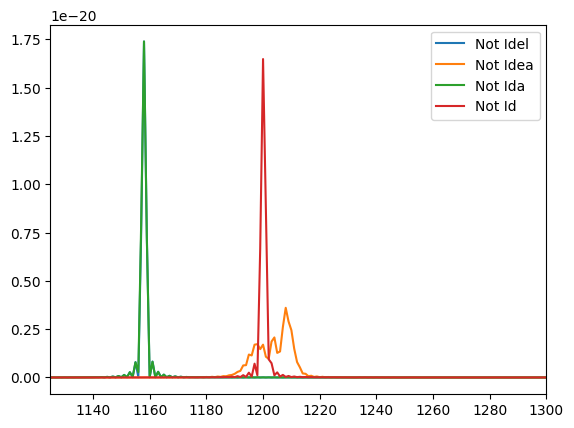

In [33]:
plt.plot((potentials[0]).get()*rescalingfac2, label='Not Idel')
plt.plot((potentials[1800]).get()*rescalingfac2, label='Not Idea')
plt.plot((potentials_ideal[0]), label='Not Ida')
plt.plot((potentials_ideal[1800]), label='Not Id')

plt.xlim(1125, 1300)
plt.legend()

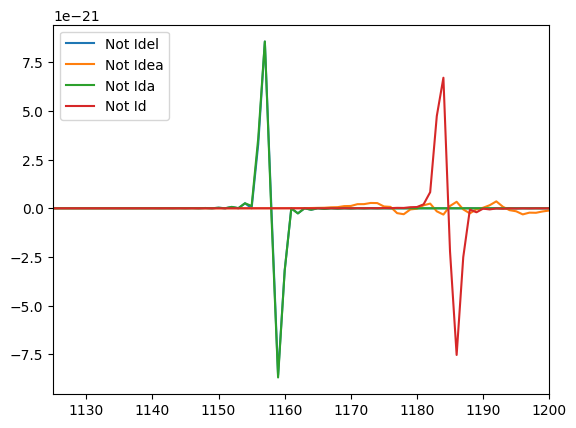

In [28]:
plt.plot(gradient(potentials[0]).get()*rescalingfac, label='Not Idel')
plt.plot(gradient(potentials[1800]).get()*rescalingfac, label='Not Idea')
plt.plot(np.gradient(potentials_ideal[0]), label='Not Ida')
plt.plot(np.gradient(potentials_ideal[1800]), label='Not Id')

plt.xlim(1125, 1200)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


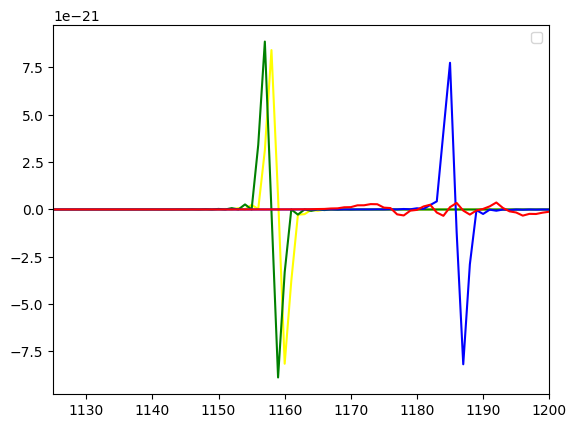

In [29]:

plt.plot(forces[0], color='yellow')
plt.plot(forces_notideal[0].get(), color='green')

plt.plot(forces[1800], color='blue')
plt.plot(forces_notideal[1800].get(), color='red')
plt.xlim(1125, 1200)
plt.legend()

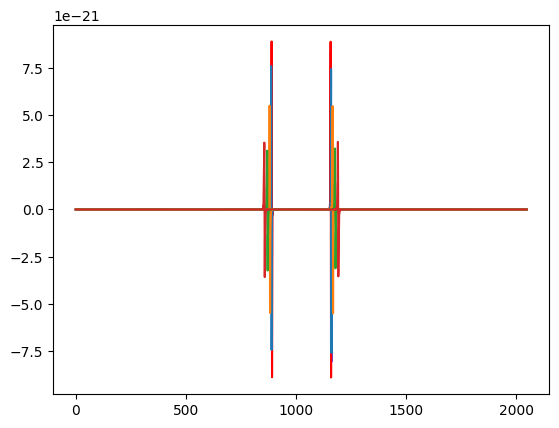

In [18]:
plt.plot(forces[0], color='blue')
plt.plot(forces_notideal[0].get(), color='red')
plt.plot(forces_notideal[2000].get())
plt.plot(forces_notideal[4000].get())
plt.plot(forces_notideal[6000].get())
plt.plot(forces_notideal[8000].get())

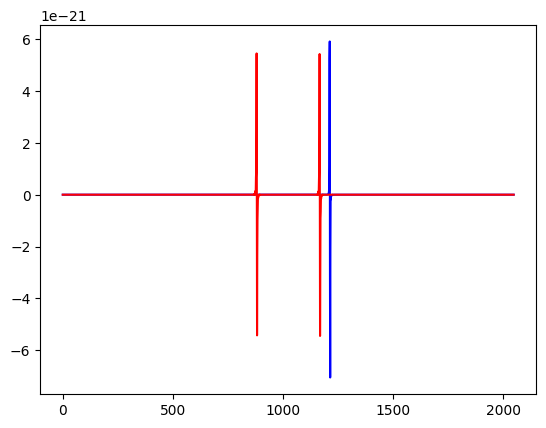

In [14]:
plt.plot(forces[-1], color='blue')
plt.plot(forces_notideal[-1].get(), color='red')

In [7]:
print(len(forces), len(forces_notideal))

14001 14001


In [4]:
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[3000:3500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())
# plt.xlim(2400,2900)

# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [5]:
from aodfunctions.general import *

In [9]:
# movetimes = np.array([80,100,120,140,160])*10**(-6)
# movetemperatures = np.array([1,10,100])*10**(-6)

movetimes = np.array([200])*10**(-6)
movetemperatures = np.array([1])*10**(-6)


ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Ideal", "Linear", 1, globalvariables)
notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Not Ideal", "Linear", 1, globalvariables)
idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Not Ideal", "SinSq", 1, globalvariables)


8.56049141843355e-21
1211.5569928191048
7.285902010583901e-21
1211.556992819102
7.863534309577126e-21
1211.5614566577076
5.1013748259902816e-21
1211.5614566577076


In [11]:
print(ideallinear[0,0][0], notideallinear[0,0][0], idealsinsq[0,0][0], notidealsinsq[0,0][0])

47.199999999999996 96.39999999999999 41.099999999999994 100.0


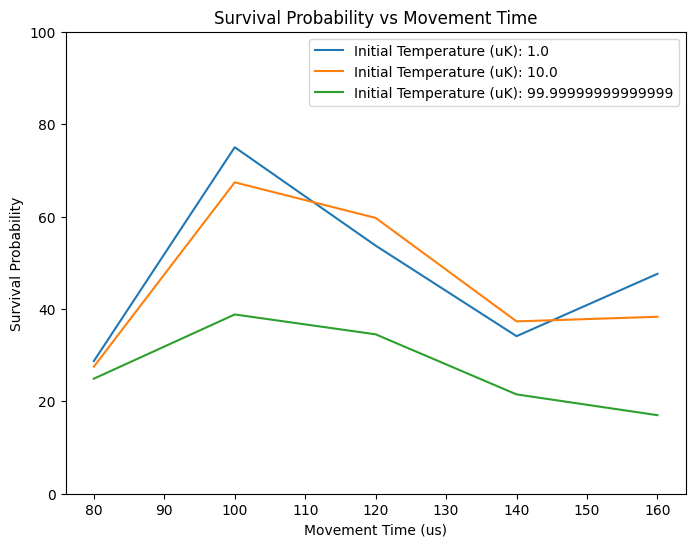

In [14]:
plots_fixeddistance(movetimes, movetemperatures, ideallinear)

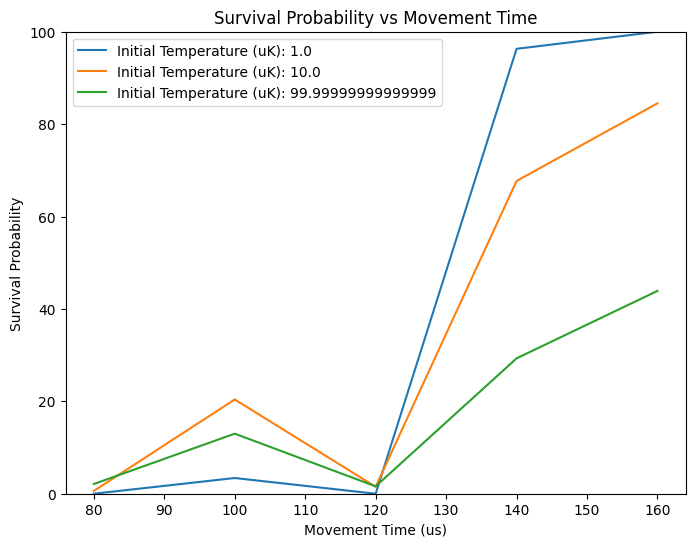

In [15]:
plots_fixeddistance(movetimes, movetemperatures, notideallinear)

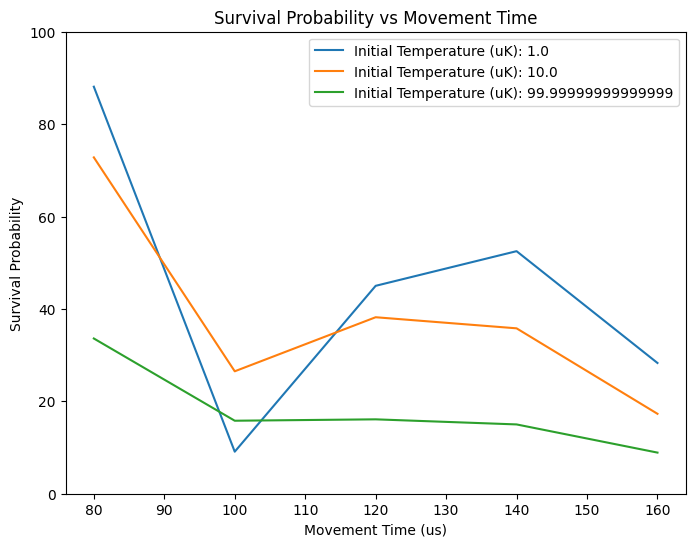

In [16]:
plots_fixeddistance(movetimes, movetemperatures, idealsinsq)

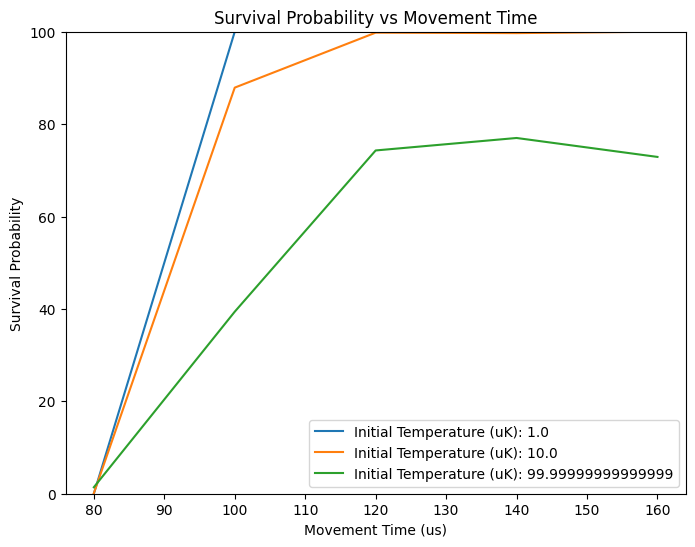

In [17]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

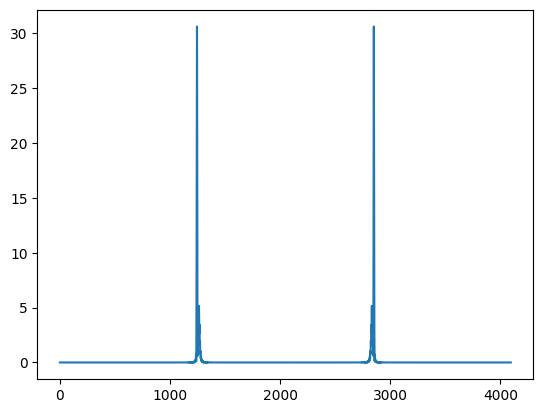

In [14]:
plt.plot(potentials[-400].get())




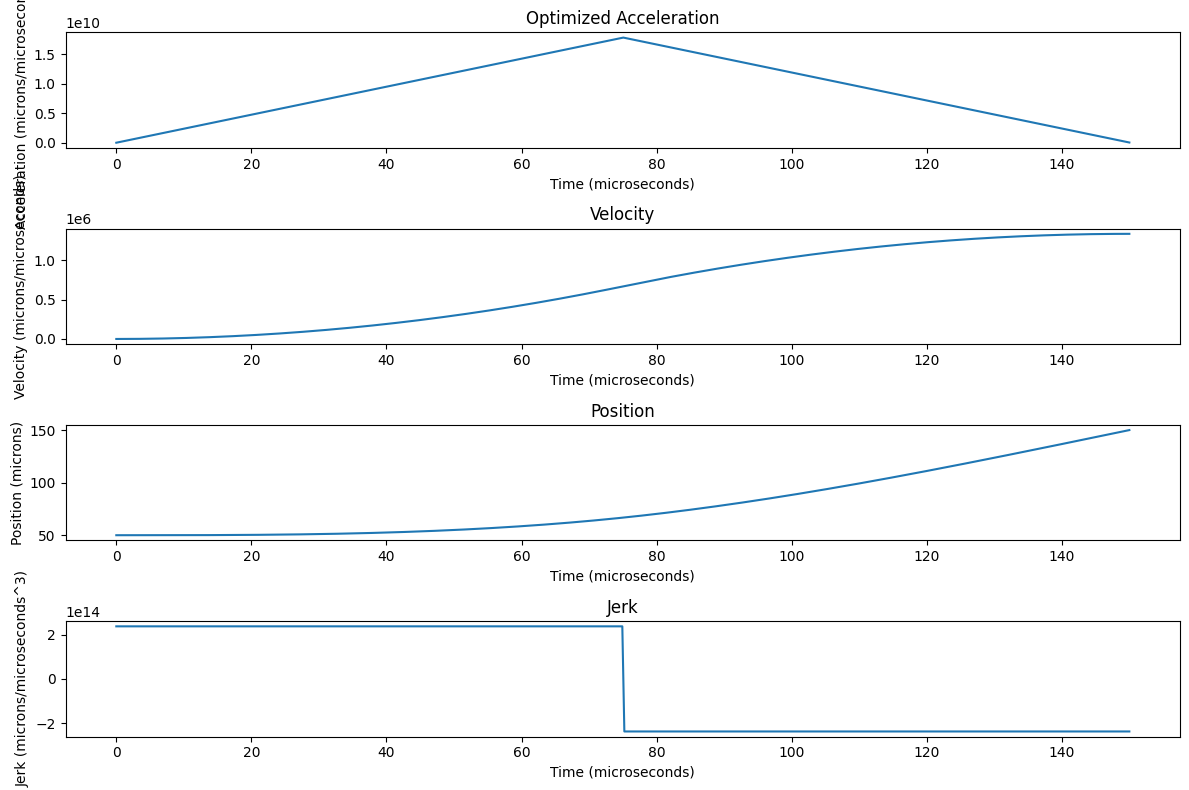

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()